In [1]:
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
import BERT4Transit
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import pyreadr
import torch.nn.functional as F
import pickle
import os
import pandas as pd

site = 'Pully_small_storage' #['Basel_small_storage','Basel_large_storage','Pully_small_storage','Lugano_small_storage','Lugano_large_storage','Pully_large_storage']
algo = 'SumSquares_noBERT2_bayesian' 
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/{site}/'
path_model = os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site}_no_c_{algo}.pth.tar')

WT = BERT4Transit.BERT4Transit(pathsite=pathsite, site=site, algo=algo, path_model=path_model)

pathsite_ground_truth = os.path.join(WT.pathsite, 'data')
site_ground_truth = WT.site
Tmax = WT.Tmax
step = WT.step
seq_len = WT.seq_len
include_concentration = WT.include_concentration
algo = WT.algo
pathsite = WT.pathsite
site = WT.site

J, Q, ET, CJ, Cout = WT.get_data(pathsite, site, include_concentration=True)


BATCH_SIZE = 10

lst_test, BATCH_SIZE = WT.get_time_points(pathsite, site, BATCH_SIZE, n_start=-365*24, n_end=-1)

data_test, timeyear_test = WT.get_data_noBERT(pathsite, site, lst_test, BATCH_SIZE=BATCH_SIZE)
input_size = data_test.shape[1]


rows_to_load = lst_test - (len(CJ)-365*24*2)
npy_file = os.path.join(pathsite_ground_truth, 'TTD.npy')
ttds = np.load(npy_file)
# keeping relevant ground truth values
idxs2keep_true_ttd = lst_test - (len(CJ)-ttds.shape[0])
ttds_true = ttds[idxs2keep_true_ttd,:]
ywf_true = np.cumsum(ttds_true, axis=1)[:,[24*30*j for j in range(1,10)]]
print('True TTDs loaded')


if algo=='Ispline':
    model = BERT4Transit.lightning_interface.LightningWATRES(model_bert, Tmax=Tmax)
elif algo=='AgeDomain':
    model = BERT4Transit.lightning_interface.LightningAgeDomain(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2_bayesian':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2_bayesian(input_size, Tmax=Tmax)
elif algo=='Weibull':
    model = BERT4Transit.lightning_interface.LightningWeibull(input_size, Tmax=Tmax)
elif algo=='SumSquares_noBERT2':
    model = BERT4Transit.lightning_interface.LightningSumSquares_noBERT2(input_size, Tmax=Tmax)
    
model.load_state_dict(torch.load(WT.path_model)['state_dict'])
model.eval()

with torch.no_grad():            
    Cout_test = torch.zeros(len(lst_test))
    CJ_test = torch.zeros((len(lst_test), Tmax))
    J_test = torch.zeros((len(lst_test), Tmax))
    Q_test = torch.zeros(len(lst_test))
    ET_test = torch.zeros(len(lst_test))
    Qinv_test = torch.zeros((len(lst_test),Tmax))
    ETinv_test = torch.zeros((len(lst_test),Tmax))

    for i,t in enumerate(lst_test):
        Cout_test[i] = Cout[t]
        CJ_test[i,:] = CJ[t-Tmax:t]
        J_test[i,:] = J[t-Tmax:t]
        Q_test[i]  = torch.sum(Q[t-Tmax:t])
        ET_test[i] = torch.sum(ET[t-Tmax:t])
        ETinv_test[i,:] = torch.flip(ET[t-Tmax:t], [0])
        Qinv_test[i,:] = torch.flip(Q[t-Tmax:t], [0])

    if algo=='Ispline':
        Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
    elif algo=='AgeDomain':
        Chat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
    elif algo in ['SumSquares','SumSquares2','SumSquares3','SumSquares_noBERT', 'SumSquares_noBERT2', 'Weibull']:
        Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        w = model.model.forward_w(data_test)
        w = w.detach().numpy()
        frac_year = timeyear_test
        frac_year = [el-int(el) for el in frac_year]
        frac_year = np.array([min([1-el, el]) for el in frac_year])
        winter_idxs = np.where(frac_year<=(2*30/365))[0]
        summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
        w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
        w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)

    elif algo in ['SumSquares_noBERT2_bayesian']:
        Chat, SThat, ywfhat, pQ = model.model.forward(data_test, J_test, CJ_test, returnpQ=True)
        w = model.model.forward_w(data_test)
        w = w.detach().numpy()
        frac_year = timeyear_test
        frac_year = [el-int(el) for el in frac_year]
        frac_year = np.array([min([1-el, el]) for el in frac_year])
        winter_idxs = np.where(frac_year<=(2*30/365))[0]
        summer_idxs = np.where(np.abs(0.5-frac_year)<=(2*30/365))[0]
        w_winter = np.mean(w[winter_idxs.astype(int),:], axis=0)
        w_summer = np.mean(w[summer_idxs.astype(int),:], axis=0)

        Chat_uncertainty, pQ_uncertainty = WT.get_uncertainties(data_test, J_test, CJ_test, n_samples=200)
        Chat_uncertainty = Chat_uncertainty

        start_index = (WT.path_model).find("BERT4TRANSIT")
        name_model = WT.path_model[start_index:-8] # -8 to remove '.pth.tar'

        print(pQ_uncertainty.shape)
        filename = os.path.join(pathsite, 'save', "pQ_uncertainties_{0}.npy".format(name_model))
        #np.save(filename, pQ_uncertainty) 
        print('Uncertainties computed')            

True TTDs loaded
torch.Size([200, 8, 43200])
Uncertainties computed


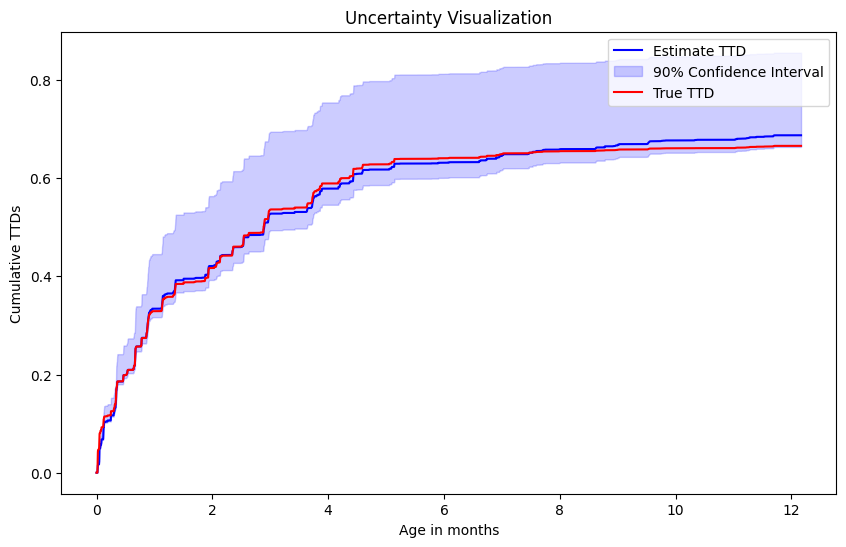

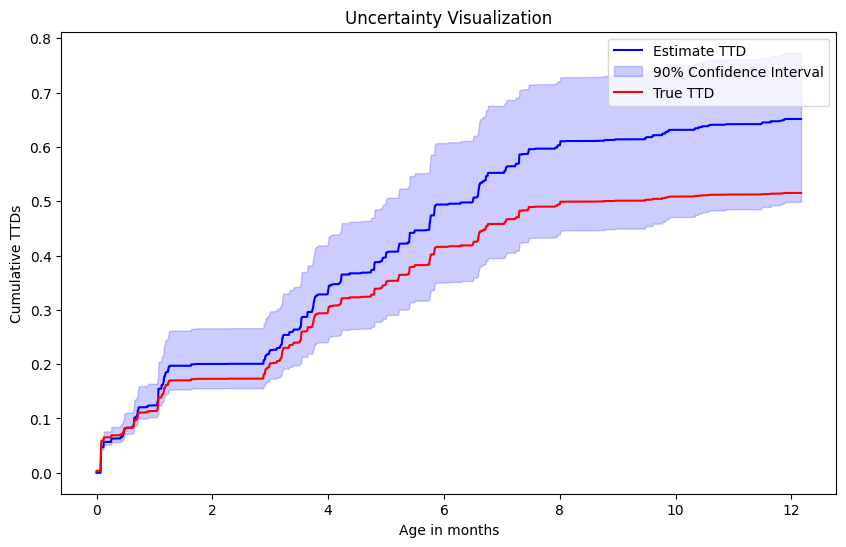

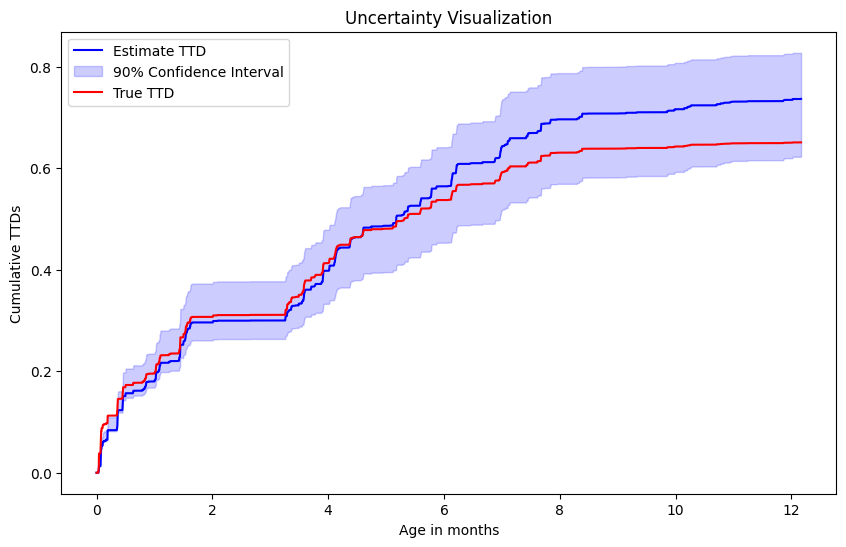

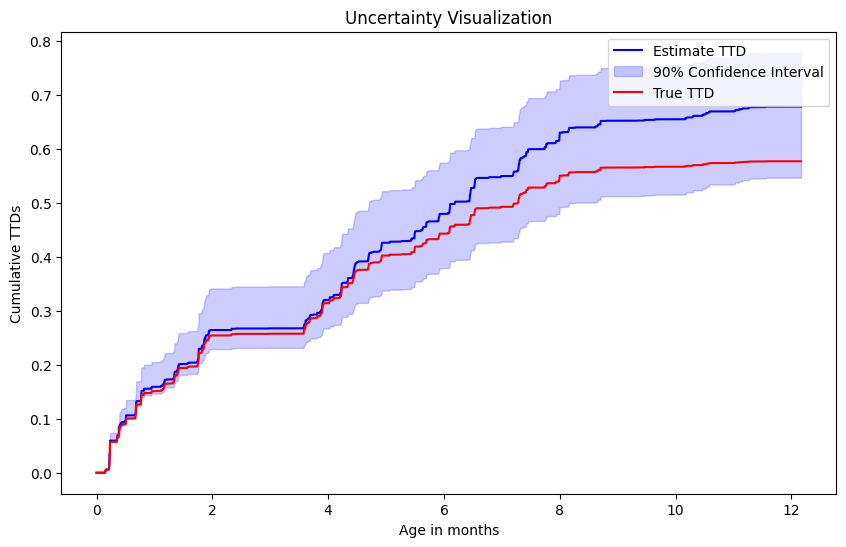

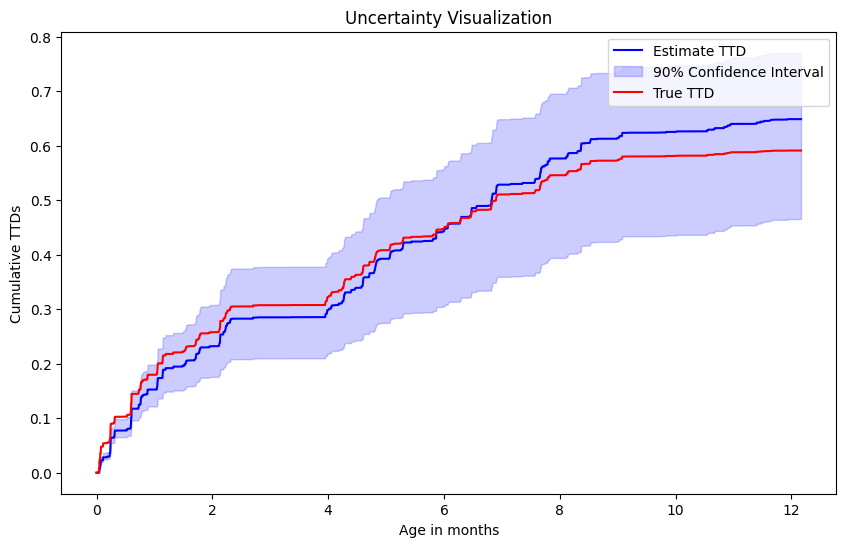

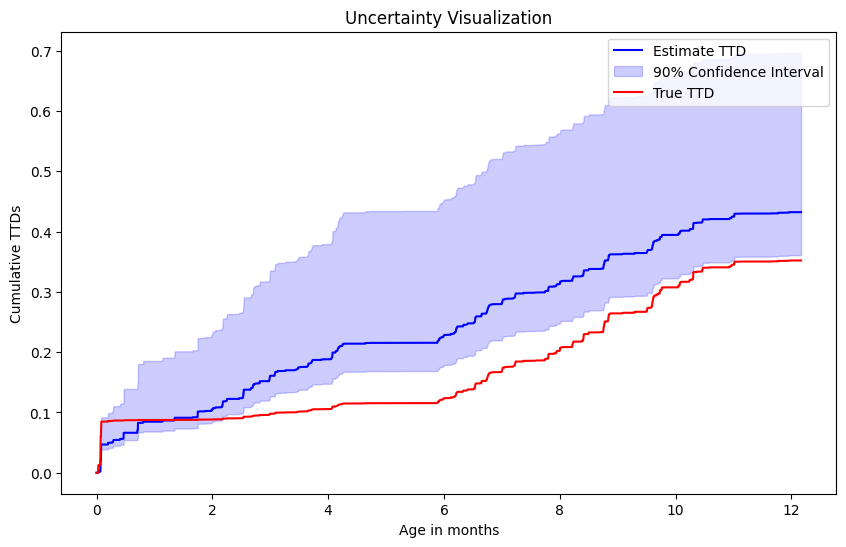

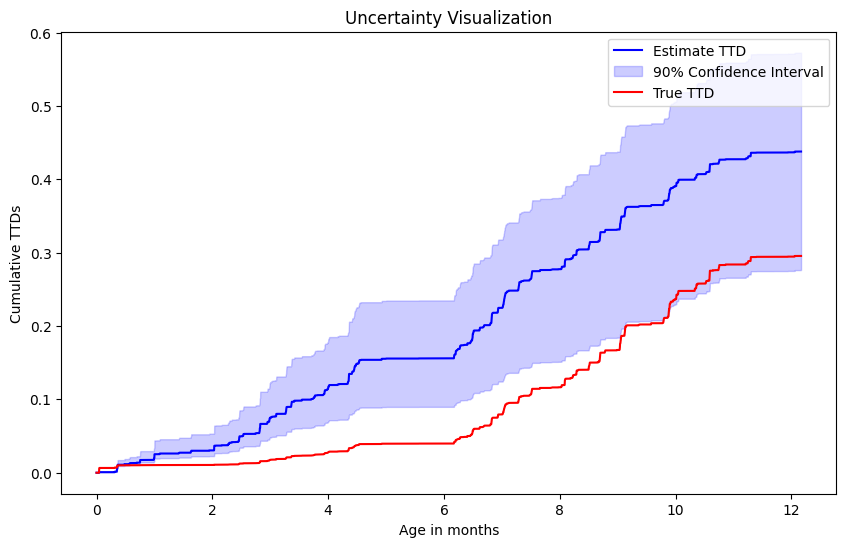

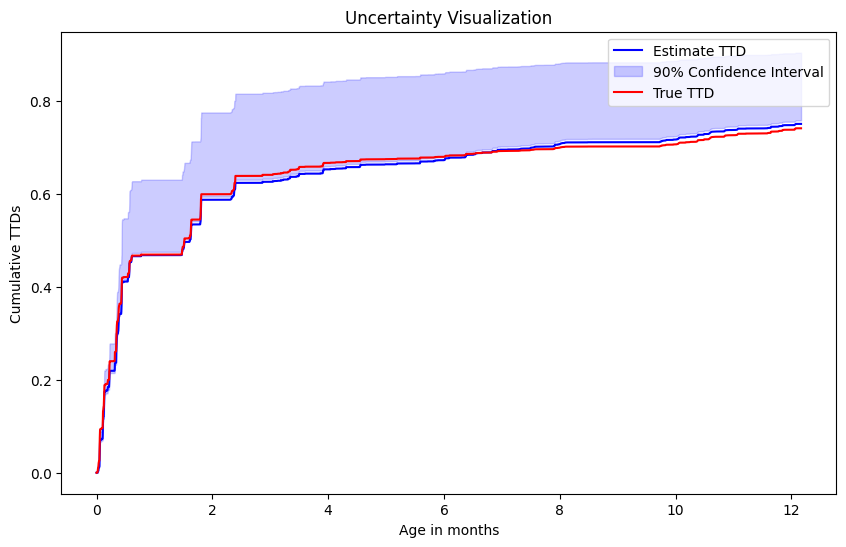

In [29]:
# Plotting
maxT = 365*24
for i in range(8):
    plt.figure(figsize=(10, 6))
    x = np.arange(maxT)/(24*30)
    estimate = np.cumsum(pQ[i,:maxT]).numpy()
    plt.plot(x, estimate, label='Estimate TTD', color='blue')
    if True:
        # Parameters
        interval_size = 90
        best_interval = None
        max_deviation = -float('inf')
        best_mean_curve = None

        sampled_functions = np.cumsum(pQ_uncertainty[:,i,:maxT], axis=1)
        
        # Loop through all valid intervals
        for start in range(100-interval_size):
            percentile_low = np.percentile(np.cumsum(pQ_uncertainty[:,i,:maxT], axis=1), start, axis=0)
            percentile_high = np.percentile(np.cumsum(pQ_uncertainty[:,i,:maxT], axis=1), interval_size+start, axis=0)
            
            # Compute deviation using Mean Squared Error (MSE)
            deviation = np.min( [np.sum(estimate-percentile_low) , np.sum(percentile_high-estimate) ])
            
            # Update if this interval is better
            if max_deviation < deviation:
                max_deviation = deviation
                best_interval = (start, start + interval_size)
    if False:
        percentile_5 = np.percentile(pQ_uncertainty[:,i,:maxT], 0, axis=0)
        percentile_95 = np.percentile(pQ_uncertainty[:,i,:maxT], 90, axis=0)
        plt.fill_between(x, np.cumsum(percentile_5), np.cumsum(percentile_95), color='blue', alpha=0.2, label='90% Confidence Interval')

    percentile_5 = np.percentile(np.cumsum(pQ_uncertainty[:,i,:maxT], axis=1), best_interval[0], axis=0)
    percentile_95 = np.percentile(np.cumsum(pQ_uncertainty[:,i,:maxT], axis=1), best_interval[1], axis=0)
    plt.fill_between(x, percentile_5, percentile_95, color='blue', alpha=0.2, label='90% Confidence Interval')
    plt.plot(x, np.cumsum(ttds_true[i,:maxT]), label='True TTD', color='red')
    
    #plt.plot(x, np.cumsum(np.mean(pQ_uncertainty[:,i,:maxT].numpy(), axis=0)), label='Mean Function', color='cyan')

    plt.title("Uncertainty Visualization")
    plt.xlabel("Age in months")
    plt.ylabel("Cumulative TTDs")
    plt.legend()
    plt.show()